# Comparing qcodes Measurement context manager with qcodes doNd functions

In this example notebook, we want to show how the qcodes Measurement can be simplified by using qcodes doNd functions. Under the hood, qcodes doNd functions use Measurement context manager to perform a measurement. It does not matter which one of these two approaches to be chosen, the result will be the same.
For the sake of this notebook, we will define some parameters for measurements and not use any specific instrument. In real measurements, these paramaters will be most likely direct or indirect parameters of instruments.

### Necessary imports

In [1]:
from qcodes import initialise_or_create_database_at
import time
import numpy as np
from qcodes.instrument.parameter import Parameter
from qcodes import load_or_create_experiment, Measurement,\
load_by_run_spec
from qcodes.utils.dataset import doNd
from qcodes.dataset.plotting import plot_dataset

### Creating a database or loading it

It is not required to have a database for this notebook, but we would like to have it. We encourage users to use plottr and view the results of this notebook using its live plotting feature (more info [How to use plottr with QCoDeS for live plotting](plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb))

In [2]:
initialise_or_create_database_at('doNd.db')

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.20it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 251.59it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.81it/s]


### One-dimensional measurement

Let's start with a simple one-dimensional case, where we sweep over the parameter 'x' and retrieve parameter 'y' and 'z' calculated as cos and sin on those swept 'x' points, repectively. We intentionally want to have two independent 'y' and 'z' calculated parameters to show how we can have more than one output parameter in the Measurement and doNd.

##### Measurement

In [3]:
# Setting up parameters
x = Parameter('x', set_cmd=None)
y = Parameter('y', get_cmd=None)
z = Parameter('z', get_cmd=None)

# Creating an experiment
exp = load_or_create_experiment('one_dimensional_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(y, setpoints=(x,))
meas.register_parameter(z, setpoints=(x,))
meas.write_period = 2

# Running Measurement
t1 = time.time()
with meas.run() as datasaver:
    for xval in np.linspace(-5, 5, 51): # sweep points for x
        datasaver.add_result(
            ('x', xval),
            ('y', np.cos(xval)),
            ('z', np.sin(xval))
            )
        time.sleep(0.1) # time in second between two sweep points
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 1. 
Meaurement took 5.572435140609741 seconds


([<AxesSubplot:title={'center':'Run #1, Experiment one_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='y'>,
  <AxesSubplot:title={'center':'Run #1, Experiment one_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='z'>],
 [None, None])

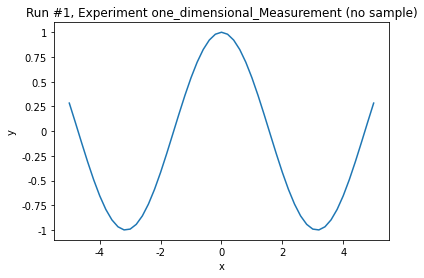

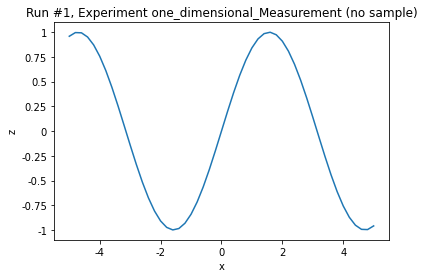

In [4]:
dataset1 = load_by_run_spec(experiment_name='one_dimensional_Measurement',\
                           captured_run_id=1)
plot_dataset(dataset1)

##### do1d

Now, we get the above result using do1d, instead. do_plot is set to True for showing the output result, but usually users like to see live plotting using tools such as plottr. Thus, do_plot can be left out to be set, which the default is False.

Starting experimental run with id: 2. 
Meaurement took 6.31328558921814 seconds


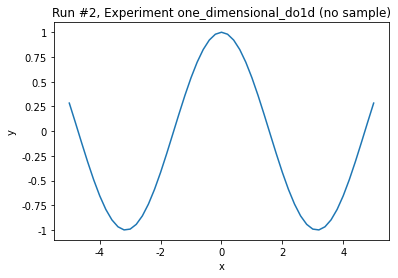

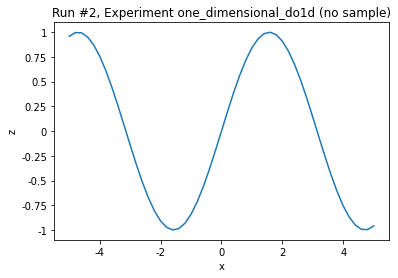

In [5]:
# Setting up parameters
x = Parameter('x', set_cmd=None)
y = Parameter('y', get_cmd=lambda: np.cos(x()))
z = Parameter('z', get_cmd=lambda: np.sin(x()))

# Creating an experiment
exp = load_or_create_experiment('one_dimensional_do1d', sample_name='no sample')

# Running measurement with do1d
t1 = time.time()
doNd.do1d(x, -5, 5, 51, 0.1, y, z, do_plot=True)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

### Two-dimensional measurement

Now, we want to run a measurement, where we calcalate 'z' parameter values depending on 'x' and 'y'. So, we will have two-dimensional sweeping and the result would be a color map.

##### Measurement

In [6]:
# Setting up parameters
x = Parameter('x')
y = Parameter('y')
z = Parameter('z')

# Creating an experiment
exp = load_or_create_experiment('two_dimensional_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(y)
meas.register_parameter(z, setpoints=(x, y))
meas.write_period = 2

# Running Measurement
t1 = time.time()
with meas.run() as datasaver:
    for xval in np.linspace(-5, 5, 51): # sweep points for x
        for yval in np.linspace(-5, 5, 51): # sweep points for y
            datasaver.add_result(
                ('x', xval),
                ('y', yval),
                ('z', np.cos(xval) * np.sin(yval)),
            )
            time.sleep(0.001)

t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 3. 
Meaurement took 40.144930839538574 seconds


([<AxesSubplot:title={'center':'Run #3, Experiment two_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x23dd9dc8308>])

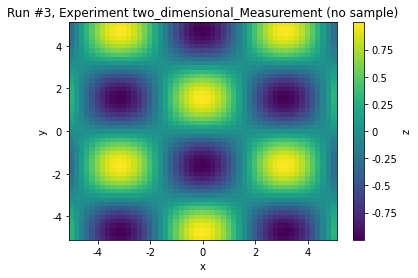

In [7]:
dataset2 = load_by_run_spec(experiment_name='two_dimensional_Measurement',\
                           captured_run_id=3)
plot_dataset(dataset2)

##### do2d

Now, we get the above result using do2d, instead.

Starting experimental run with id: 4. 
Meaurement took 41.3532292842865 seconds


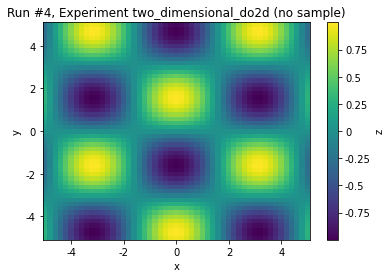

In [8]:
# Setting up parameters
x = Parameter('x', set_cmd=None)
y = Parameter('y', set_cmd=None)
z = Parameter('z', get_cmd=lambda: np.cos(x())*np.sin(y()))

# Creating an experiment
exp = load_or_create_experiment('two_dimensional_do2d', sample_name='no sample')

# Running measurement with do2d
t1 = time.time()
doNd.do2d(x, -5, 5, 51, 0.001, y, -5, 5, 51, 0.001, z, do_plot=True)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Just like one-dimensional case, in two-dimensional sweeping, it is possible to have more than one output parameter.